In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint

from scikeras.wrappers import KerasRegressor

import math

2024-04-15 00:03:42.411607: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-15 00:03:42.440293: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-15 00:03:42.440315: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-15 00:03:42.440335: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-15 00:03:42.445855: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-15 00:03:42.446295: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [3]:
df_train = pd.read_csv("../data/train.csv")
df_test = pd.read_csv("../data/test.csv")

In [4]:
def remove_outliers(df, quantile=0.05):
    Q1 = df.quantile(quantile)
    Q3 = df.quantile(1-quantile)
    IQR = Q3 - Q1
    
    return df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]

def apply_feature_engineering(df: pd.DataFrame, keep_outliers) -> pd.DataFrame:
    df["total_bedrooms"] = df["total_bedrooms"].fillna(df["total_bedrooms"].mean())
    custom_encoding = {"ISLAND": 0, "NEAR OCEAN": 1, "NEAR BAY": 2, "<1H OCEAN": 3, "INLAND": 4}
    df["ocean_proximity_enc"] = df.replace({"ocean_proximity": custom_encoding})["ocean_proximity"]
    df = df.drop("ocean_proximity", axis=1)
    df["rooms_per_bedroom"] = df["total_rooms"] / df["total_bedrooms"]
    df["rooms_per_household"] = df["total_rooms"] / df["households"]
    df["encoded_position"] = df["longitude"] + df["latitude"]
    df["population_per_bedrooms"] = df["population"] / df["total_bedrooms"]
    df["target"] = df["median_house_value"]
    df = df.drop("median_house_value", axis=1)
    if not keep_outliers:
        df = remove_outliers(df, 0.05)
    return df

In [5]:
df_train = apply_feature_engineering(df_train, True)
df_test = apply_feature_engineering(df_test, False)

X_train = df_train.drop("target", axis=1)
y_train = df_train["target"]

X_test = df_test.drop("target", axis=1)
y_test = df_test["target"]

/tmp/ipykernel_1770/340611199.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["ocean_proximity_enc"] = df.replace({"ocean_proximity": custom_encoding})["ocean_proximity"]
/tmp/ipykernel_1770/340611199.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["ocean_proximity_enc"] = df.replace({"ocean_proximity": custom_encoding})["ocean_proximity"]


## Baseline

In [6]:
pipe = Pipeline([])
pipe.steps.append(("scaler", StandardScaler()))
pipe.steps.append(("reg", LinearRegression()))
pipe.fit(X_train, y_train)

y_predict = pipe.predict(X_test)
metrics.root_mean_squared_error(y_test, y_predict)

69088.63550189085

In [255]:
def plot_rmse(history):
    loss = np.sqrt(history["loss"])
    val_loss = np.sqrt(history["val_loss"])
    fig = plt.figure(figsize=(12, 6), dpi=80)
    plt.plot(loss, label="Training")
    plt.plot(val_loss, label="Validation")
    plt.legend()
    plt.ylabel("RMSE")
    plt.xlabel("Epoch")

def rmse(y_true, y_pred):
    return tf.math.reduce_mean(tf.math.square(y_pred - y_true))**0.5

In [185]:
def build_model(inputs: int,
                layers: list,
                layers_per_dropout: int = 0,
                dropout_rate: int = 0,
                activation_func = "relu",
                loss_func = "mean_squared_error",
                optimizer = "adam"):
    
    model = Sequential()
    model.add(Input((inputs, )))
    count = 0
    for n_nodes in layers:
        model.add(Dense(n_nodes, activation=activation_func))
        count += 1
        if layers_per_dropout == count:
            model.add(Dropout(dropout_rate))
            count == 0

    model.add(Dense(1))
    
    model.compile(optimizer=optimizer, loss=loss_func, metrics=[rmse])
    return model

def build_keras_regressor(model,
                          epochs = 100,
                          batch_size = 100,
                          verbose = 0,
                          patience = None):
    if patience is not None:
        early_stop = EarlyStopping(patience = patience, restore_best_weights = True)
        callbacks = [early_stop]
    else:
        callbacks = []
    return KerasRegressor(model=model,
                          batch_size=batch_size,
                          epochs=epochs,
                          verbose=verbose,
                          callbacks=callbacks)

# DELETE ME
def build_keras_regressor_from_zero(inputs: int,
                                    layers: list,
                                    layers_per_dropout: int = 0,
                                    dropout_rate: int = 0,
                                    activation_func = "relu",
                                    loss_func = "mean_squared_error",
                                    optimizer = "adam",
                                    epochs = 100,
                                    batch_size = 100,
                                    verbose = 0,
                                    patience = None):
    model = build_model(inputs, layers, layers_per_dropout, dropout_rate, activation_func, loss_func, optimizer)
    return build_keras_regressor(model, epochs, batch_size, verbose, patience)

## Simple Neural Network

In [170]:
pipe = Pipeline([])
pipe.steps.append(("scaler", StandardScaler()))

pipe.fit(X_train)
X_test_mod = pipe.transform(X_test)

keras_reg = build_keras_regressor(build_model(len(X_train.columns), [10]), patience=20, epochs=1000, verbose=1)
pipe.steps.append(("keras", keras_reg))

pipe.fit(X_train, y_train, keras__validation_data=(X_test_mod, y_test))

Epoch 1/1000
124/124 [==============================] - 0s 2ms/step - loss: 56430313472.0000 - rmse: 237040.2031 - val_loss: 54600265728.0000 - val_rmse: 233332.7500
Epoch 2/1000
124/124 [==============================] - 0s 1ms/step - loss: 56429346816.0000 - rmse: 237209.8594 - val_loss: 54599127040.0000 - val_rmse: 233330.3906
Epoch 3/1000
124/124 [==============================] - 0s 1ms/step - loss: 56427823104.0000 - rmse: 237168.4531 - val_loss: 54597435392.0000 - val_rmse: 233326.6875
Epoch 4/1000
124/124 [==============================] - 0s 1000us/step - loss: 56425684992.0000 - rmse: 237225.1875 - val_loss: 54595117056.0000 - val_rmse: 233321.7500
Epoch 5/1000
124/124 [==============================] - 0s 1ms/step - loss: 56422883328.0000 - rmse: 237118.1875 - val_loss: 54592200704.0000 - val_rmse: 233315.4688
Epoch 6/1000
124/124 [==============================] - 0s 998us/step - loss: 56419389440.0000 - rmse: 237109.9844 - val_loss: 54588633088.0000 - val_rmse: 233307.8750

Pipeline(steps=[('scaler', StandardScaler()),
                ('keras',
                 KerasRegressor(batch_size=100, callbacks=[<keras.src.callbacks.EarlyStopping object at 0x7f679c77d810>], epochs=1000, model=<keras.src.engine.sequential.Sequential object at 0x7f685c3ea110>))])

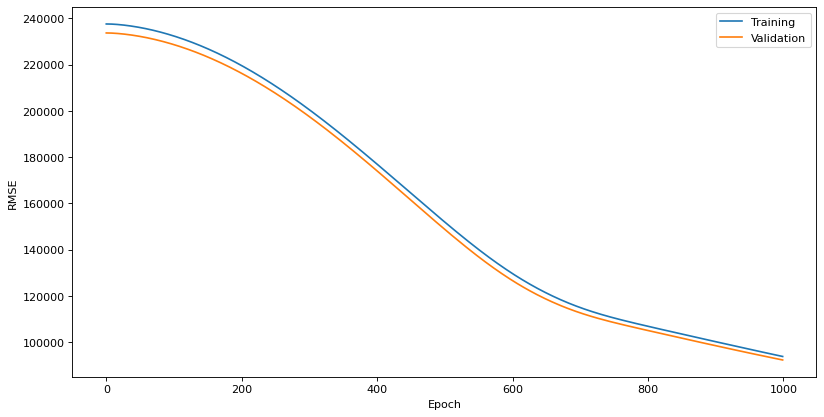

In [171]:
history = pipe.named_steps['keras'].history_
plot_rmse(history)

In [172]:
y_pred = pipe.predict(X_test)
metrics.root_mean_squared_error(y_test, y_pred)

41/41 [==============================] - 0s 540us/step


92278.7030034817

## Grid Search

In [257]:
layers_configs = [[16],
                  [16, 16],
                  [16, 32, 16],
                  [32, 32],
                  [32, 64, 32],
                  [64, 64, 64],
                  [64 for i in range(6)]]

optimizers = ["adam", "adadelta"]
loss_funcs = ["mean_squared_error"]
layers_per_dropout = [0, 1, 2]
dropout_rates = [0.05, 0.1, 0.2]
activation_funcs = ["relu"]
epochs = [1000]
batch_sizes = [16, 32, 64]

params = {"model__layers": layers_configs,
          "model__inputs": [len(X_train.columns)],
          "model__optimizer": optimizers,
          "model__layers_per_dropout": layers_per_dropout,
          "model__dropout_rate": dropout_rates,
          "model__activation_func": activation_funcs,
          "epochs": epochs,
          "batch_size": batch_sizes
         }

pipe = Pipeline([])
pipe.steps.append(("scaler", StandardScaler()))

pipe.fit(X_train)
X_grid = pipe.transform(X_train)
X_test_mod = pipe.transform(X_test)

early_stop = EarlyStopping(patience = 100, restore_best_weights = True)

keras_reg = KerasRegressor(model=build_model,
                           verbose=0,
                           #validation_split=0.2,
                           callbacks=[early_stop])

grid_search = GridSearchCV(keras_reg, param_grid=params, n_jobs=40, cv=5)

In [258]:
# This takes a lot of time
# grid_search.fit(X_grid, y_train, validation_data=(X_test_mod, y_test))

2024-04-12 07:16:36.930185: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-12 07:16:36.943946: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-12 07:16:36.964209: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-12 07:16:36.964250: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-12 07:16:36.964271: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-12 07:16:36.970636: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda d

GridSearchCV(cv=5,
             estimator=KerasRegressor(callbacks=[<keras.src.callbacks.EarlyStopping object at 0x7f669c3b7710>], model=<function build_model at 0x7f69bc4dc180>, verbose=0),
             n_jobs=40,
             param_grid={'batch_size': [16, 32, 64], 'epochs': [1],
                         'model__activation_func': ['relu'],
                         'model__dropout_rate': [0.05, 0.1, 0.2],
                         'model__inputs': [13],
                         'model__layers': [[16], [16, 16], [16, 32, 16],
                                           [32, 32], [32, 64, 32], [64, 64, 64],
                                           [64, 64, 64, 64, 64, 64]],
                         'model__layers_per_dropout': [0, 1, 2],
                         'model__optimizer': ['adam', 'adadelta']})

In [259]:
y_pred = grid_search.predict(X_test_mod)
metrics.root_mean_squared_error(y_pred, y_test)

68788.67117816221

In [ ]:
grid_search.best_estimator_

In [ ]:
grid_search.best_params_

In [271]:
# TESTING

from keras.optimizers import Adam

keras_reg = KerasRegressor(model=build_model(layers=[256, 128, 64, 64],
                                             inputs=len(X_train.columns),
                                             layers_per_dropout=2,
                                             dropout_rate=0.05,
                                             optimizer=Adam(learning_rate=0.01)
                                            ),
                                               
                           verbose=1,
                           epochs=200,
                           batch_size=16,
                           callbacks=[early_stop])
keras_reg.fit(X_grid, y_train, validation_data=(X_test_mod, y_test))

Epoch 1/200
774/774 [==============================] - 2s 1ms/step - loss: 6688390656.0000 - rmse: 73303.2734 - val_loss: 4470821376.0000 - val_rmse: 64529.1016
Epoch 2/200
774/774 [==============================] - 1s 1ms/step - loss: 4555659776.0000 - rmse: 64674.5469 - val_loss: 4235092992.0000 - val_rmse: 62122.8633
Epoch 3/200
774/774 [==============================] - 1s 1ms/step - loss: 4368386560.0000 - rmse: 63387.0664 - val_loss: 4452144128.0000 - val_rmse: 63872.0234
Epoch 4/200
774/774 [==============================] - 1s 1ms/step - loss: 4382045696.0000 - rmse: 63598.9570 - val_loss: 4627243520.0000 - val_rmse: 64880.4961
Epoch 5/200
774/774 [==============================] - 1s 1ms/step - loss: 4254313216.0000 - rmse: 62661.5039 - val_loss: 4080361472.0000 - val_rmse: 61144.7773
Epoch 6/200
774/774 [==============================] - 1s 1ms/step - loss: 4350677504.0000 - rmse: 63067.7383 - val_loss: 4174814464.0000 - val_rmse: 61725.3047
Epoch 7/200
774/774 [=============

KerasRegressor(
	model=<keras.src.engine.sequential.Sequential object at 0x7f665c780c10>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=16
	validation_batch_size=None
	verbose=1
	callbacks=[<keras.src.callbacks.EarlyStopping object at 0x7f669c3b7710>]
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=200
)

In [272]:
y_pred = keras_reg.predict(X_test_mod)
metrics.root_mean_squared_error(y_pred, y_test)

255/255 [==============================] - 0s 564us/step


50295.05434053333

In [273]:
keras_reg = KerasRegressor(model=build_model(layers=[256, 128, 64, 64, 64],
                                             inputs=len(X_train.columns),
                                             layers_per_dropout=2,
                                             dropout_rate=0.05,
                                             optimizer=Adam(learning_rate=0.005)
                                            ),
                                               
                           verbose=1,
                           epochs=200,
                           batch_size=8,
                           callbacks=[early_stop])
keras_reg.fit(X_grid, y_train, validation_data=(X_test_mod, y_test))

Epoch 1/200
1548/1548 [==============================] - 2s 1ms/step - loss: 5885607424.0000 - rmse: 68554.8281 - val_loss: 4954129408.0000 - val_rmse: 64851.1094
Epoch 2/200
1548/1548 [==============================] - 2s 1ms/step - loss: 4541582848.0000 - rmse: 62808.9102 - val_loss: 5336471552.0000 - val_rmse: 67772.9453
Epoch 3/200
1548/1548 [==============================] - 2s 1ms/step - loss: 4609136640.0000 - rmse: 62132.2070 - val_loss: 4480321536.0000 - val_rmse: 61648.2930
Epoch 4/200
1548/1548 [==============================] - 2s 1ms/step - loss: 4304500224.0000 - rmse: 60461.6992 - val_loss: 4101219072.0000 - val_rmse: 59651.4023
Epoch 5/200
1548/1548 [==============================] - 2s 1ms/step - loss: 4022134016.0000 - rmse: 58795.6641 - val_loss: 3832297728.0000 - val_rmse: 56501.5625
Epoch 6/200
1548/1548 [==============================] - 2s 1ms/step - loss: 3848140800.0000 - rmse: 57492.0469 - val_loss: 3498525440.0000 - val_rmse: 54206.9570
Epoch 7/200
1548/1548 

KerasRegressor(
	model=<keras.src.engine.sequential.Sequential object at 0x7f663c62e7d0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=8
	validation_batch_size=None
	verbose=1
	callbacks=[<keras.src.callbacks.EarlyStopping object at 0x7f669c3b7710>]
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=200
)

In [274]:
y_pred = keras_reg.predict(X_test_mod)
metrics.root_mean_squared_error(y_pred, y_test)

509/509 [==============================] - 0s 547us/step


50464.51091234318

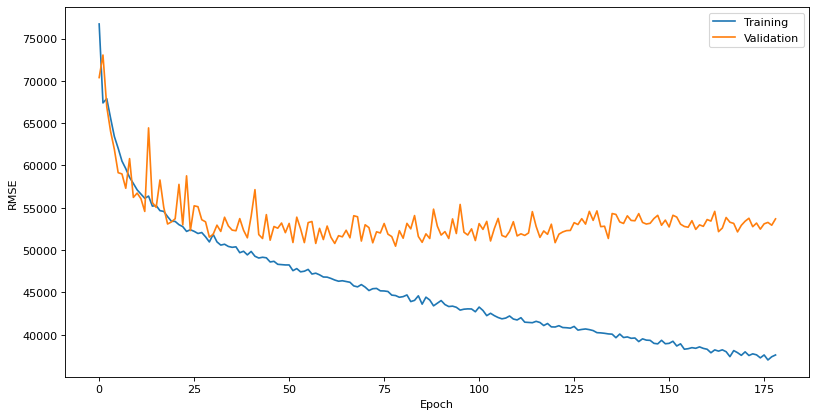

In [275]:
plot_rmse(keras_reg.history_)